In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import os

In [3]:
# 파일 경로 설정
file_path = 'WISDM_ar_v1.1_raw.txt'

# --- 1. 파일 불러오기 및 데이터 전처리 ---
print("데이터 전처리 시작...")
try:
    parsed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip().replace(';', '')
            if not line:
                continue
            parts = line.split(',')
            
            if len(parts) > 6:
                activity = parts[1] + ',' + parts[2]
                rest = parts[3:]
                parts = [parts[0], activity] + rest

            if len(parts) == 6:
                parsed_data.append(parts)

    df = pd.DataFrame(parsed_data, columns=['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel'])

    df['user'] = pd.to_numeric(df['user'], errors='coerce')
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['x-accel'] = pd.to_numeric(df['x-accel'], errors='coerce')
    df['y-accel'] = pd.to_numeric(df['y-accel'], errors='coerce')
    df['z-accel'] = pd.to_numeric(df['z-accel'], errors='coerce')
    df['activity'] = df['activity'].str.strip()
    df.dropna(inplace=True)

    print("데이터 전처리 완료. 데이터 정보:")
    df.info()

except FileNotFoundError:
    print(f"오류: {file_path} 파일을 찾을 수 없습니다.")
    exit()

데이터 전처리 시작...
데이터 전처리 완료. 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 1086465 entries, 0 to 1098198
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086465 non-null  int64  
 1   activity   1086465 non-null  object 
 2   timestamp  1086465 non-null  float64
 3   x-accel    1086465 non-null  float64
 4   y-accel    1086465 non-null  float64
 5   z-accel    1086465 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 58.0+ MB


In [5]:
# --- 2. 특징과 라벨 ---
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
FEATURES = ['x-accel', 'y-accel', 'z-accel']
LABELS = ['activity_encoded']

# --- 3. 슬라이딩 윈도우 및 CNN-LSTM 데이터 준비 ---
def prepare_data_for_cnn_lstm(data, window_size, step_size, n_steps, n_length):
    X_list, y_list = [], []
    users = []
    
    # 사용자 ID 별로 데이터 윈도우 생성
    for user_id in data['user'].unique():
        user_data = data[data['user'] == user_id]
        num_data_points = user_data.shape[0]
        
        for i in range(0, num_data_points - window_size, step_size):
            window = user_data.iloc[i : i + window_size]
            features = window[FEATURES].values
            labels = window[LABELS].values
            
            # 윈도우 내 라벨이 하나라도 있다면 가장 빈번한 라벨을 선택
            if len(np.unique(labels)) > 0:
                most_common_label = Counter(labels.flatten()).most_common(1)[0][0]
                X_list.append(features.reshape((n_steps, n_length, len(FEATURES))))
                y_list.append(most_common_label)
                users.append(user_id)
                
    return np.array(X_list), np.array(y_list), np.array(users)

WINDOW_SIZE = 50
STEP_SIZE = 25
N_STEPS = 5
N_LENGTH = 10

X, y, users = prepare_data_for_cnn_lstm(df, WINDOW_SIZE, STEP_SIZE, N_STEPS, N_LENGTH)
print("\nCNN-LSTM을 위한 데이터 준비 완료.")
print(f"X.shape: {X.shape}, y.shape: {y.shape}, users.shape: {users.shape}")


CNN-LSTM을 위한 데이터 준비 완료.
X.shape: (43405, 5, 10, 3), y.shape: (43405,), users.shape: (43405,)


In [7]:
# --- 4. 학습/테스트 데이터 분리 (Subject-wise) ---
print("\nSubject-wise 분할 시작...")
unique_users = np.unique(users)
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

# 훈련 및 테스트 데이터 인덱스 필터링
train_indices = np.isin(users, train_users)
test_indices = np.isin(users, test_users)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

print("\nSubject-wise 분할 완료.")
print(f"훈련 피험자 수: {len(train_users)}")
print(f"테스트 피험자 수: {len(test_users)}")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")



Subject-wise 분할 시작...

Subject-wise 분할 완료.
훈련 피험자 수: 28
테스트 피험자 수: 8
X_train.shape: (32752, 5, 10, 3), y_train.shape: (32752,)
X_test.shape: (10653, 5, 10, 3), y_test.shape: (10653,)


In [9]:
# --- 5. 모델 구성 (CNN-LSTM) ---
def build_cnn_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
            input_shape=input_shape
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        
        keras.layers.LSTM(units=100, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(units=100),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(units=100, activation='relu'),
        keras.layers.Dense(units=num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

num_classes = len(label_encoder.classes_)
lstm_model = build_cnn_lstm_model(input_shape=(N_STEPS, N_LENGTH, len(FEATURES)),
                                   num_classes=num_classes)
print("\n모델 요약:")
lstm_model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



모델 요약:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 5, 8, 64)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 5, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 5, 100)              │         142,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 234,546 (916.20 KB)

 Trainable params: 234,546 (916.20 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# --- 6. 모델 학습 ---
EPOCHS = 20
BATCH_SIZE = 64
history = lstm_model.fit(X_train, y_train,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(X_test, y_test),
                         verbose=1)

Epoch 1/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7781 - loss: 0.6431 - val_accuracy: 0.7856 - val_loss: 0.6013
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9137 - loss: 0.2397 - val_accuracy: 0.8135 - val_loss: 0.6143
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9421 - loss: 0.1636 - val_accuracy: 0.8132 - val_loss: 0.6184
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9574 - loss: 0.1252 - val_accuracy: 0.8480 - val_loss: 0.5050
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9648 - loss: 0.1012 - val_accuracy: 0.8474 - val_loss: 0.5861
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9695 - loss: 0.0858 - val_accuracy: 0.8523 - val_loss: 0.5548
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9744 - loss: 0.0739 - val_accuracy: 0.8618 - val_loss: 0.5512
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9780 - loss: 0.0639 - val_acc

In [17]:
# --- 7. 평가 및 시각화 ---
print("\n--- 모델 평가 결과 ---")
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 손실 (Test Loss): {loss:.4f}")
print(f"테스트 정확도 (Test Accuracy): {accuracy:.4f}")


--- 모델 평가 결과 ---
테스트 손실 (Test Loss): 1.0089
테스트 정확도 (Test Accuracy): 0.8275


333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
### 분류 보고서 ###
              precision    recall  f1-score   support

  Downstairs       0.70      0.57      0.63      1133
     Jogging       0.95      0.96      0.96      3404
     Sitting       0.82      0.81      0.82       439
    Standing       0.65      0.96      0.77       375
    Upstairs       0.55      0.73      0.62      1644
     Walking       0.96      0.81      0.88      3658

    accuracy                           0.83     10653
   macro avg       0.77      0.81      0.78     10653
weighted avg       0.85      0.83      0.83     10653



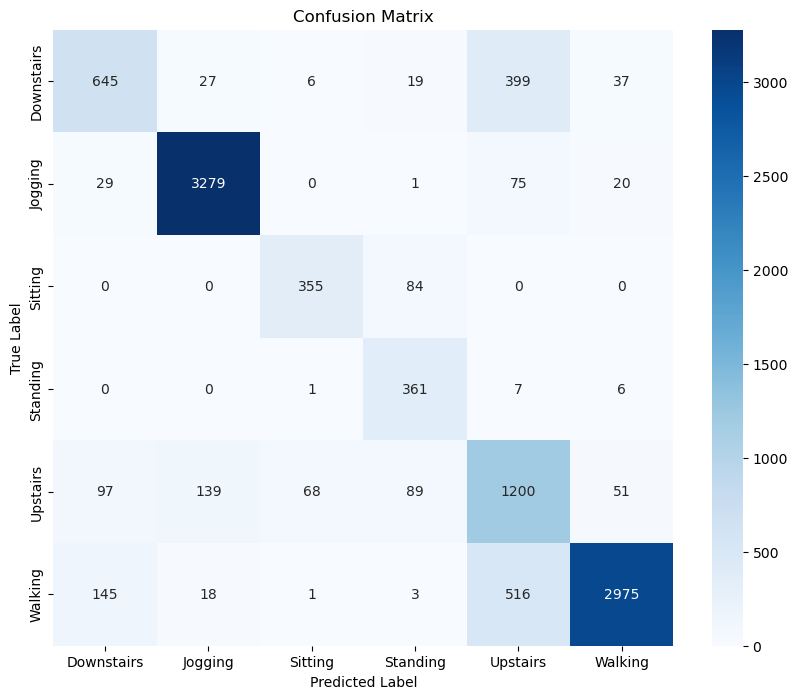

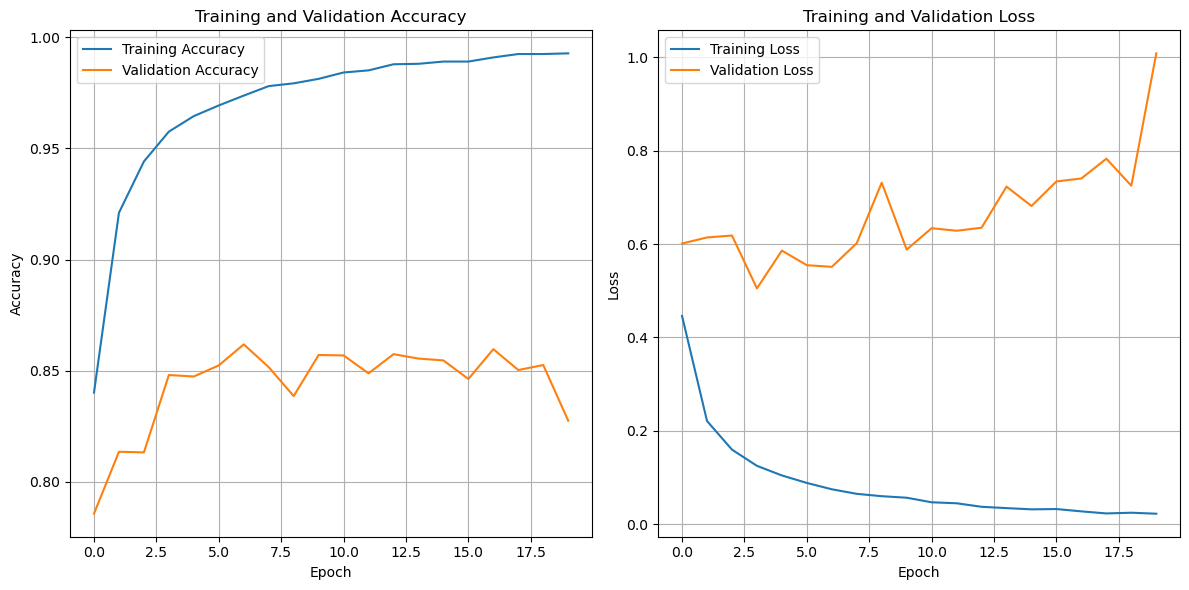

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
#---시각화 ---

# 모델 예측
y_pred = lstm_model.predict(X_test).argmax(axis=-1)

# 분류 보고서 출력
print("### 분류 보고서 ###")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 매트릭스 생성
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 매트릭스 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 훈련 및 검증 정확도/손실 시각화 (이전 코드 재사용)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()